# Linear Regression
Haytham Mohamed

INFS 890 - Spring 2020

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [186]:
is_factored_features = False

In [187]:
# 1- read data file
# 1- read processed file
file_dir = '../../data/processed-data/'

if is_factored_features:
    data_file = 'factored_dataset.csv'
else:
    data_file = 'normalized_dataset.csv'

data = pd.read_csv(file_dir + data_file)



In [188]:
data.head(5)

,ltcy,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,svc_req_size,svc_resp_size,svc_pods,svc_req_rate
0,0.332,0.557,0.332,0.325,0.037,16.982,1.591,3.206,0.002,0.012,7.000,0.980
1,0.400,0.616,0.300,0.351,0.047,20.583,1.608,3.552,0.003,0.019,7.000,1.620
2,0.469,0.608,0.316,0.362,0.039,19.448,1.390,3.586,0.003,0.024,7.000,2.180
3,0.490,0.624,0.300,0.362,0.108,17.319,1.730,3.512,0.003,0.022,6.000,2.130
4,0.500,0.608,0.316,0.374,0.133,16.650,1.917,3.449,0.003,0.023,3.000,2.220


In [189]:
targets = data['ltcy']
inputs = data.drop(['ltcy'], axis=1)

#inputs_scaled = scaler.fit_transform(inputs)
#x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=0.1, random_state=365)

# for better convergence and result scale target to values between 0 - 1
maxltcy = targets.max()
y_train = y_train / maxltcy
y_test = y_test / maxltcy


In [190]:
def getPipeline(factored):
    # standardize the features
    scaler = StandardScaler()

    # using SelectFromModel metatransformer to select features
    clf = LassoCV()
    sfm = SelectFromModel(clf, threshold=0.01)

    # regression model
    reg = LinearRegression(normalize=False)  # normalize false bacause we are going to use the scaler

    if not factored:
        pline = Pipeline([
            ('scaler', scaler),
            ('feature_selection', sfm),
            ('regression', reg)
        ])
    else:
        pline = Pipeline([
            ('scaler', scaler),
            ('regression', reg)
        ])    
    
    return pline



In [191]:
pline = getPipeline(is_factored_features)
kfold = KFold(n_splits=10)
results = cross_val_score(pline, x_train , y_train, cv=kfold, scoring='neg_mean_squared_error')

print ("Done..!")

y_hat = pline.fit(x_train, y_train)

Done..!


In [192]:
y_hat = pline.predict(x_train)

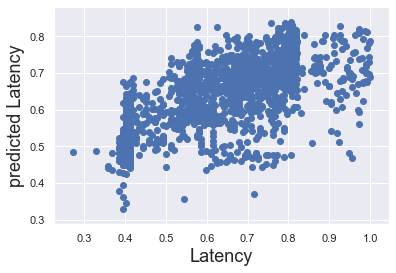

In [193]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

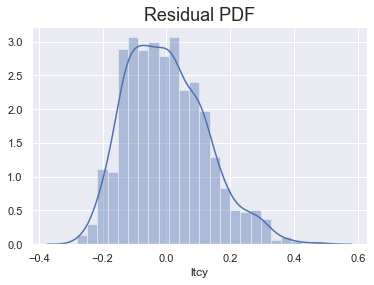

In [194]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

In [195]:
# R-Squared
pline.score(x_train, y_train)

0.3625448311760473

In [196]:
pline.named_steps.regression.intercept_

0.6391233170884889

In [197]:
pline.named_steps.regression.coef_

array([ 0.02644514,  0.01285988, -0.08897132, -0.01572074,  0.15725378])

In [198]:
if not is_factored_features:
    selector = pline.named_steps.feature_selection
    selected_features = selector.transform(inputs)
    number_of_features = selected_features.shape[1]

    features = []
    for i in range(number_of_features):
        features.append('Feature_' + str(i))

    reg_summary = pd.DataFrame(features, columns=['features'])
    reg_summary['weights'] = pline.named_steps.regression.coef_
    reg_summary

In [199]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.10 (0.07) 0.00 0.49 MSE


### Testing

In [200]:
y_hat_test = pline.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

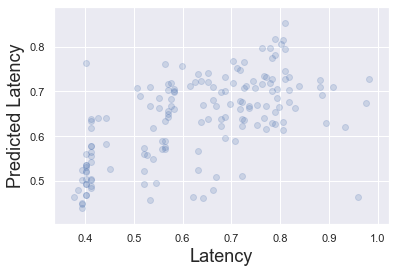

In [201]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

In [202]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,2.019,1.767
1,1.951,1.778
2,1.750,1.682
3,2.078,2.266
4,2.133,1.819


In [203]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,2.019,1.767,0.252,14.234
1,1.951,1.778,0.173,9.740
2,1.750,1.682,0.068,4.067
3,2.078,2.266,-0.187,8.263
4,2.133,1.819,0.313,17.231
...,...,...,...,...
154,2.261,2.238,0.023,1.041
155,1.681,1.496,0.186,12.405
156,2.053,2.018,0.034,1.695
157,2.059,1.870,0.189,10.090


In [204]:
perf.describe()

,prediction,target,residual,difference%
count,159.000,159.000,159.000,159.000
mean,1.902,1.904,-0.002,10.075
std,0.180,0.297,0.243,7.272
min,1.551,1.457,-1.017,0.019
25%,1.762,1.682,-0.154,4.452
50%,1.929,1.900,0.037,9.029
75%,2.035,2.148,0.168,14.280
max,2.347,2.672,0.649,43.401


In [205]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
81,1.95,1.95,0.00,0.02
49,1.69,1.68,0.00,0.19
28,1.88,1.89,-0.01,0.49
72,2.24,2.23,0.01,0.54
158,2.18,2.20,-0.01,0.68
115,1.77,1.76,0.01,0.78
150,2.17,2.19,-0.02,0.89
153,1.73,1.71,0.02,0.94
154,2.26,2.24,0.02,1.04
53,1.78,1.76,0.02,1.22


# Prediction Accuracy

In [206]:
# validation mean_absolute_percentage_error (MAPE)
test_error =  np.absolute(perf['residual'] / perf['target'])
mean_error = np.mean(test_error)
min_error = np.min(test_error)
max_error = np.max(test_error)
std_error = np.std(test_error)

print("Mean Absolute Percentate Error std of error (MAPE): [mean: %.2f std: %.2f max: %.2f min: %.2f]" \
      % (mean_error, std_error, max_error, min_error))


Mean Absolute Percentate Error std of error (MAPE): [mean: 0.10 std: 0.07 max: 0.43 min: 0.00]


In [207]:
# validation mean_squared_error  (MSE)
test_error =  np.power(perf['residual'] , 2)
mean_error = np.mean(test_error)
min_error = np.min(test_error)
max_error = np.max(test_error)
std_error = np.std(test_error)

print("Mean Squared Error (MSE): [mean: %.2f std: %.2f max: %.2f min: %.2f]" \
      % (mean_error, std_error, max_error, min_error))


Mean Squared Error (MSE): [mean: 0.06 std: 0.11 max: 1.03 min: 0.00]


R2 is a statistic that will give some information about the goodness of fit of a model. In regression, the R2 coefficient of determination is a statistical measure of how well the regression predictions approximate the real data points. An R2 of 1 indicates that the regression predictions perfectly fit the data.

In [208]:
# R-Squared 
# = 1 -  ( sum of squared residual  / sum of squared variance )
# sum of variance squared = sum (( y - y-mean ) ** 2)
# sum of residual squared = sum (( y-hat - y-mean ) ** 2)
# where y is the observed target, y-mean is the mean of observed target, y-hat is a predicted value

y_mean = np.mean(targets)
sum_squared_residual = np.sum(np.power(perf['residual'] , 2))
sum_squared_variance = np.sum(np.power(targets - y_mean , 2))

R_squared = 1 - ( sum_squared_residual / sum_squared_variance )

R_squared


0.837405870917278